In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, compute_class_weight
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()

import torch

In [2]:
#funzioni per gestire gli array da passare alle loss

def to_tensor_complementare(array):
    v_array = torch.tensor(array, dtype=torch.float32).unsqueeze(1)
    complementare = 1 - v_array # torch.empty([array.shape[0], 1])
    res = torch.cat((v_array, complementare), -1)
    return res      #    res[:,1] = 1 - res[:,0]  

def to_tensor(array):
    v_array = torch.tensor(array, dtype=torch.float32).unsqueeze(1)
    return v_array

def s(array):
    return np.random.permutation(array)

def calc_loss(loss_funx, complementare = False, reduction = False, all_weights=None):    
    # sceglie la funzione per gestire gli array
    if complementare:
        v = to_tensor_complementare
    else:
        v = to_tensor
    loss_zeri = loss_funx(v(y_pred_zeri), v(y_true_shuf))
    loss_uni = loss_funx(v(y_pred_uni), v(y_true_shuf))
    loss_middle = loss_funx(v(y_pred_middle), v(y_true_shuf))
    loss_optimal = loss_funx(v(y_pred_optimal), v(y_true))
    
    
    
    if reduction:
        final_loss_zeri = (loss_zeri * all_weights(y_true) ).mean()
        final_loss_uni = (loss_uni * all_weights(y_true) ).mean()
        final_loss_middle = (loss_middle * all_weights(y_true) ).mean()
        final_loss_optimal = (loss_optimal * all_weights(y_true) ).mean()
        return final_loss_zeri.item(), final_loss_middle.item(), final_loss_uni.item(), final_loss_optimal.item()
        
    else:
        return loss_zeri.item(), loss_middle.item(), loss_uni.item(), loss_optimal.item()
        
    
def print_f(four_losses):
    loss_zeri, loss_middle, loss_uni, loss_optimal = four_losses
    just = 6
    print(f"Zeri: {str(round(loss_zeri, 5)).ljust(just, ' ')} \
              Centro: {str(round(loss_middle, 5)).ljust(just, ' ')} \
              Uni: {str(round(loss_uni, 5)).ljust(just, ' ')} \
              Ottimale: {str(round(loss_optimal, 5)).ljust(just, ' ')}")
    

# Verifica loss con pesi

### valori veri e predetti

In [3]:
#y_true = np.array([1  , 1  , 1   , 0   , 0   , 0   , 0   , 0   , 0  , 0  , 0  , 0  , 0  ])
y_true = np.array([1]*50 + [0]*950)
y_true_shuf = s(y_true)
#y_pred = np.array([0.4, 0.4, 0.4, 0.35, 0.28, 0.45, 0.25, 0.45, 0.1, 0.1, 0.1, 0.1, 0.2])
y_pred_zeri = np.random.normal(0.2,0.05,1000)
#y_pred2 = np.array([0.99, 0.99, 0.99, 0.05, 0.02, 0.05, 0.025, 0.045, 0.1, 0.1, 0.1, 0.1, 0.02])
y_pred_uni = np.random.normal(0.8,0.05,1000)
y_pred_middle = np.random.normal(0.5,0.05,1000)
y_pred_optimal = np.concatenate(( np.random.normal(0.8,0.05,50) , np.random.normal(0.2,0.05,950) )) 


uni = y_true.sum()
tot = len(y_true)
##p_zeri = (tot-uni)/tot
##p_uni = uni/tot
#print(tot/(tot-uni), tot/uni)
p_zeri = (tot-uni)
p_uni = uni
print(f"p_zeri: {p_zeri}, p_uni {p_uni}")


p_zeri: 950, p_uni 50


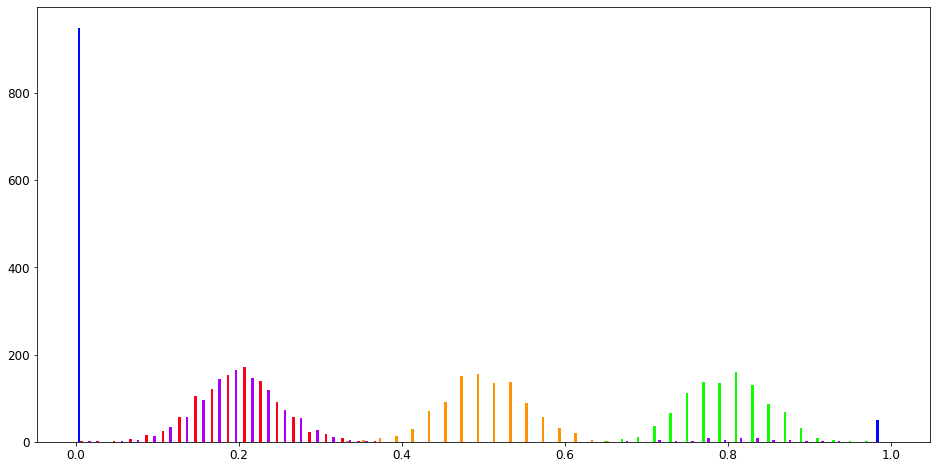

In [4]:
plt.hist((y_true, y_pred_zeri, y_pred_uni, y_pred_middle, y_pred_optimal), bins=50);

# Funzioni di Loss

### Loss normale

In [5]:
criterion = torch.nn.BCEWithLogitsLoss() ##reduction='sum')

### Loss pesata per le due classi

In [9]:
#class_weights = class_weight.compute_class_weight('balanced',np.unique(y_true),y_true)
##class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y_true), y = y_true)
##print(class_weights.tolist())



#custom_w = [300,0.01]
#custom_w_inverted = [0.01, 300]
custom_w = [p_zeri,p_uni] 
custom_w_inverted = [p_uni,p_zeri]

#pos_weight = torch.tensor([tot/(tot-uni), tot/uni])
#pos_inverted = torch.tensor([(tot-uni)/tot, uni/tot])

##weights = torch.tensor(class_weights, dtype=torch.float32)
custom_weights = torch.tensor(custom_w, dtype=torch.float32)
custom_weights_inverted = torch.tensor(custom_w_inverted, dtype=torch.float32)
criterion_w =  torch.nn.BCEWithLogitsLoss(pos_weight=custom_weights) ##, reduction='sum')
criterion_w_inv =  torch.nn.BCEWithLogitsLoss(pos_weight=custom_weights_inverted)

950 50


### Loss con un peso

In [10]:
uni = y_true.sum()
tot = len(y_true)
p_zeri = (tot-uni)/tot
##p_uni = uni/totuni = y_true.sum()
p_uni = (tot-uni)/uni


mono_weight = torch.tensor(p_uni, dtype=torch.float32)
##mono_weight_inv = torch.tensor(p_uni, dtype=torch.float32)
criterion_mono = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight) ##, reduction='sum')
##criterion_mono_inv = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight_inv)

### Loss senza peso, ma lo posso applicare dopo

In [11]:
criterion_red = torch.nn.BCEWithLogitsLoss(reduction='none')
diz = {c:w for c, w in enumerate(custom_w)}
diz_inv = {c:w for c, w in enumerate(custom_w_inverted)}
all_weights = lambda y_true: torch.tensor([diz[y] for y in y_true])
all_weights_inv = lambda y_true: torch.tensor([diz_inv[y] for y in y_true])

In [12]:
diz

{0: 950, 1: 50}

## AUC e valori di Loss

In [21]:
# AUC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_true_shuf, y_pred_zeri)
auc_score2 = roc_auc_score(y_true_shuf, y_pred_uni)
auc_score3 = roc_auc_score(y_true_shuf, y_pred_middle)
auc_score4 = roc_auc_score(y_true, y_pred_optimal)


round(auc_score, 5),round( auc_score2, 5), round(auc_score3, 5), round(auc_score4, 5)
# quindi vediamo che la auc è migliore in pred1 cioè quando sono più vicini allo zero

(0.48415, 0.49335, 0.55766, 1.0)

### le loss sono errori: più grande la loss e peggiore è la performance della rete, 
### e tanto più la rete verrà allontanata da quei valori di output dalla backpropagation

In [120]:
print_f(calc_loss(criterion, complementare=False))

Zeri: 0.7884               Centro: 0.95057               Uni: 1.13028               Ottimale: 0.77706


### sopra si vede quindi che la situazione ottimale ha una loss più piccola delle altre, ce lo aspettiamo sempre
### ma quella con valori più vicini allo zero ha loss più piccola dei valori vicini a uno o in mezzo: male!
### perché sono di più gli zeri e quindi, a meno che non specifichiamo pesi diversi, 
### per la loss è preferibile che siano tutti zeri rispetto a tutti uni, perché è più facile da calcolare

In [42]:
# specifichiamo i pesi con un array a due valori, uno per classe
print(f"pesi: {custom_w}")
print_f(calc_loss(criterion_w, complementare=True))
print(f"pesi: {custom_w_inverted}")
print_f(calc_loss(criterion_w_inv, complementare=True))

pesi: [950, 50]
Zeri: 46915.01953               Centro: 46021.57031               Uni: 47089.15625               Ottimale: 35956.89453
pesi: [50, 950]
Zeri: 169.01045               Centro: 214.74556               Uni: 271.12326               Ottimale: 168.32022


pesi: [0.95, 0.05]
Zeri: 0.43093               Centro: 0.51021               Uni: 0.59951               Ottimale: 0.41685
pesi: [0.05, 0.95]
Zeri: 0.57628               Centro: 0.70276               Uni: 0.84684               Ottimale: 0.56724


pesi: [300, 0.01]
Zeri: 4.91496               Centro: 3.98557               Uni: 3.39074               Ottimale: 3.18722
pesi: [0.01, 300]
Zeri: 53.34117               Centro: 68.16825               Uni: 85.82793               Ottimale: 53.31562


### mi piace questo ora

In [40]:
print_f(calc_loss(criterion, complementare=False))

Zeri: 789.46271               Centro: 948.01715               Uni: 1131.34668               Ottimale: 776.52765


In [41]:
# loss con un peso per la prima classe
print(f"pesi: {mono_weight.item()}")
print_f(calc_loss(criterion_mono, complementare=False))
##print(f"pesi: {mono_weight_inv.item()}")
##print_f(calc_loss(criterion_mono_inv, complementare=False))

pesi: 19.0
Zeri: 1328.1012               Centro: 1375.42114               Uni: 1463.04712               Ottimale: 1108.70789


pesi: 950.0
Zeri: 29.35212               Centro: 23.40309               Uni: 18.88713               Ottimale: 18.58475
pesi: 50.0
Zeri: 2.26169               Centro: 2.10899               Uni: 2.04854               Ottimale: 1.69548


pesi: 0.949999988079071
Zeri: 0.78621               Centro: 0.94937               Uni: 1.13036               Ottimale: 0.77613
pesi: 0.05000000074505806
Zeri: 0.75959               Centro: 0.92816               Uni: 1.11348               Ottimale: 0.75942


pesi: 0.009999999776482582
Zeri: 0.75897               Centro: 0.92679               Uni: 1.11272               Ottimale: 0.75867
pesi: 300.0
Zeri: 9.76767               Centro: 7.91859               Uni: 6.73556               Ottimale: 6.33098


In [125]:
# loss senza pesi, no reduction, moltiplico dopo i pesi
print(f"pesi: {diz}")
print_f(calc_loss(criterion_red, complementare=False, reduction=True, all_weights=all_weights))
print()
print(f"pesi: {diz_inv}")
print_f(calc_loss(criterion_red, complementare=False, reduction=True, all_weights=all_weights_inv))

pesi: {0: 950, 1: 50}
Zeri: 713.50446               Centro: 860.26831               Uni: 1022.90533               Ottimale: 703.24097

pesi: {0: 50, 1: 950}
Zeri: 74.89825               Centro: 90.3044               Uni: 107.37681               Ottimale: 73.82088


pesi: {0: 0.95, 1: 0.05}
Zeri: 0.71286               Centro: 0.86025               Uni: 1.02383               Ottimale: 0.70324

pesi: {0: 0.05, 1: 0.95}
Zeri: 0.07483               Centro: 0.0903               Uni: 0.10747               Ottimale: 0.07382


pesi: {0: 300, 1: 0.01}
Zeri: 224.72733               Centro: 270.88303               Uni: 322.55612               Ottimale: 221.46301

pesi: {0: 0.01, 1: 300}
Zeri: 11.83522               Centro: 14.26601               Uni: 16.98736               Ottimale: 11.66331


In [127]:
# la loss con riduzione successiva mi sembra sempre pessima, non cambia l'ordine di importanza delle loss

# Voglio ottenere una loss simmetrica rispetto al centro, rieseguo varie volte al variare della distribuzione di output

In [6]:
  
def get_losses_mono(mu, p_uni):
    y_pred = np.random.normal(mu, 0.5, 1000) 
    mono_weight_inv = torch.tensor(p_uni, dtype=torch.float32)
    criterion_mono = torch.nn.BCEWithLogitsLoss(pos_weight=mono_weight_inv)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion_mono(to_tensor(y_pred), to_tensor(y_true_shuf))
    return (loss.item())

def get_losses_bi(mu, biweights):
    y_pred = np.random.normal(mu, 0.5, 1000)
    custom_w = torch.tensor(biweights, dtype=torch.float32) ##[p_zeri,p_uni]
    criterion_bi = torch.nn.BCEWithLogitsLoss(pos_weight=custom_w)
    #print(f"pesi: {mono_weight.item()}")
    loss = criterion_bi(to_tensor_complementare(y_pred), to_tensor_complementare(y_true_shuf))
    return (loss.item())

def get_losses_red(mu, all_weights):
    y_pred = np.random.normal(mu, 0.5, 1000)
    crit = torch.nn.BCEWithLogitsLoss(reduction='none')
    loss = crit(to_tensor(y_pred), to_tensor(y_true_shuf))
    final_loss = (loss.squeeze() * all_weights).mean()
    return (final_loss.item())


def get_losses_bceloss(mu):
    y_pred = np.random.normal(mu, 0.5, 1000)
    criterion_bceloss = torch.nn.BCELoss()
    loss = criterion_bceloss(torch.sigmoid(to_tensor(y_pred)), to_tensor(y_true_shuf))
    return (loss.item())

def get_losses_bceloss_red(mu, all_weights):
    y_pred = np.random.normal(mu, 0.5, 1000)
    criterion_wo_sigmoid_red = torch.nn.BCELoss(reduction='none')
    loss = criterion_wo_sigmoid_red(torch.sigmoid(to_tensor(y_pred)), to_tensor(y_true_shuf))
    final_loss = (loss * all_weights(y_true_shuf)).mean()
    return (final_loss.item())

In [7]:
def plot_losses_w_mu_weight(loss_f, p_array, notitle=False):
    xs = np.arange(-3, 3, 0.001)
    ##p_array = range(23, 38, 1)
    ##p_array = np.arange(0, 5, 0.1)
    cols = 7
    rows = len(p_array) // cols + int((len(p_array)%cols)>0)
    fig, ax = plt.subplots(rows,cols, figsize=(30,4*rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(p_array):
                p = p_array[idx]
                losses_mu = [loss_f(mu, p) for mu in xs]
                ax[i][j].scatter(xs, losses_mu)
                if not notitle:
                    ax[i][j].set_title(p)
    plt.show()

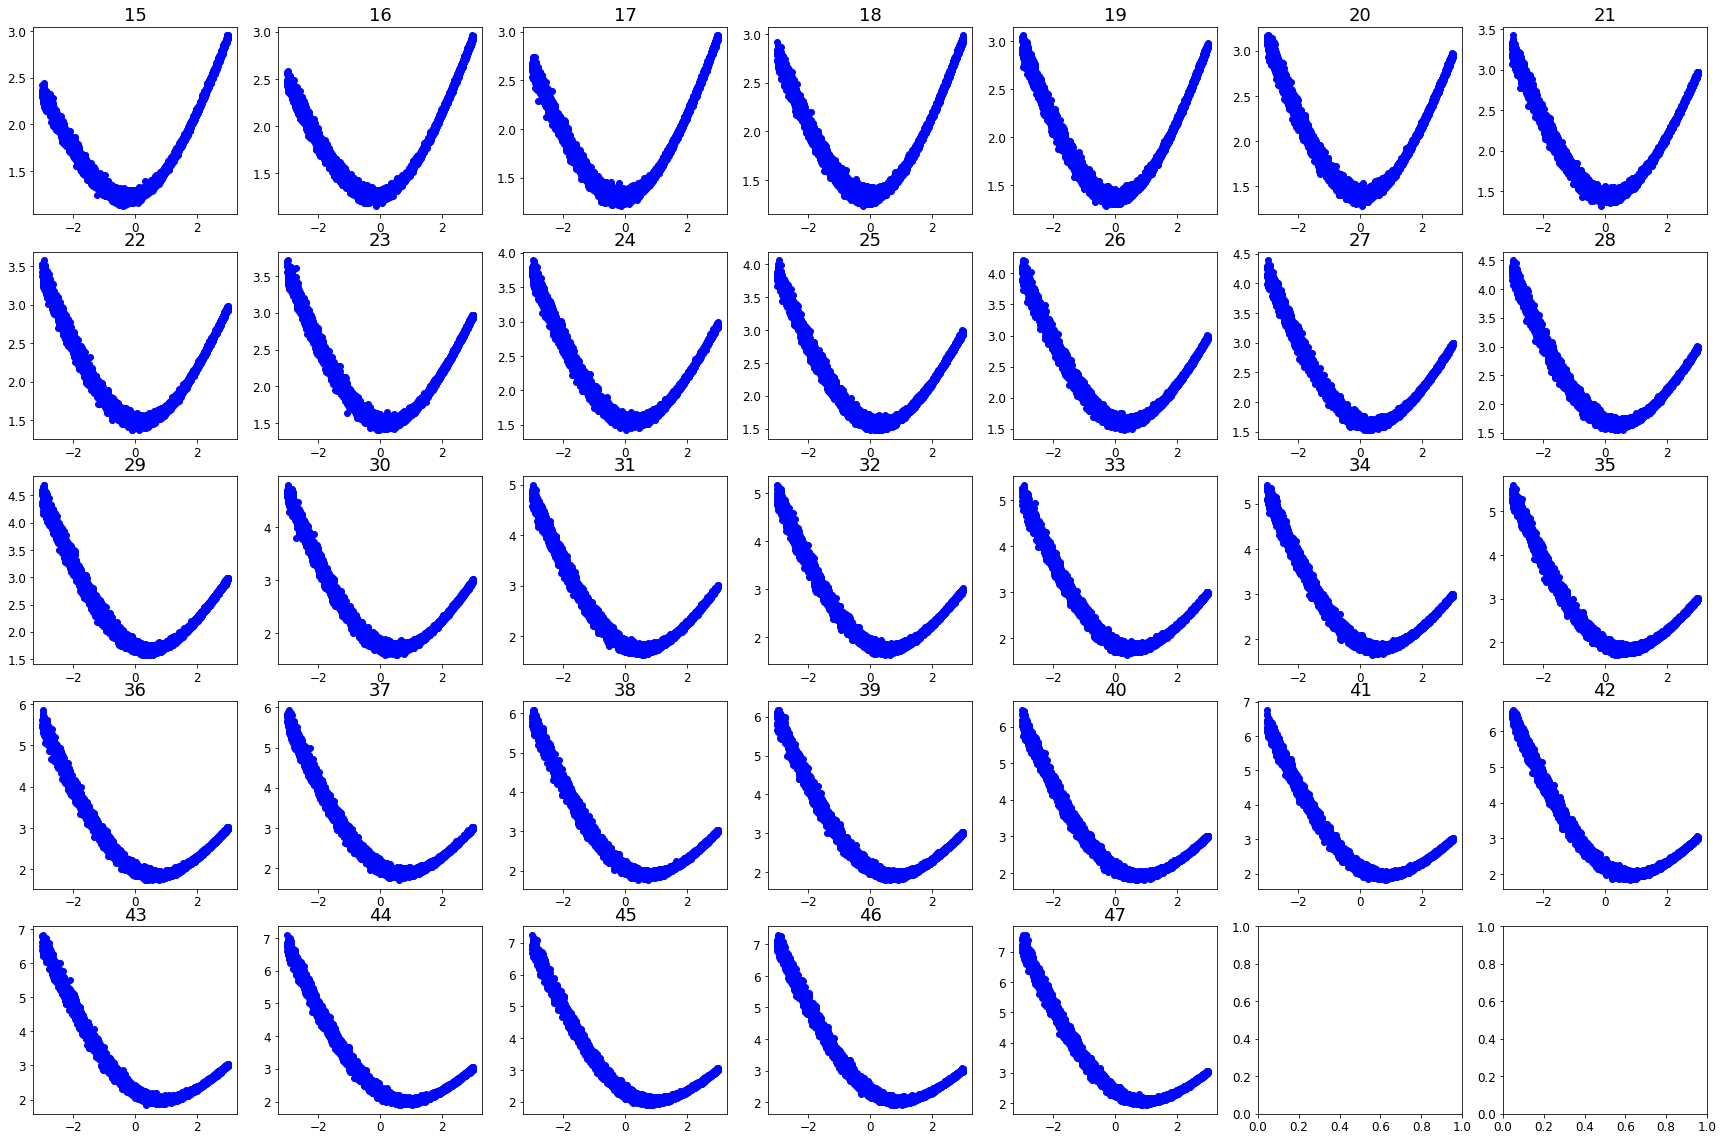

In [63]:
p_array = range(15, 48, 1)
plot_losses_w_mu_weight(get_losses_mono, p_array)

## Di seguito appare evidente come sarebbe meglio usare la loss con entrambi i pesi , mentre la loss con un peso solo non si capisce come è collegato il singolo peso al conteggio dei vqlori del dataset...
sembra che p a 950/50 corrisponda un peso singolo di 30... perché?

Perché avevo dimenticato che tutti i valori devono passare sotto sigmoide, quindi in realtà cerco la simmetria attorno a 0, non attorno 0.5.
E probabilmente raddoppiare l'array con 1-valore introduce una simmetria doppia...? non so

In [25]:
950/50

19.0

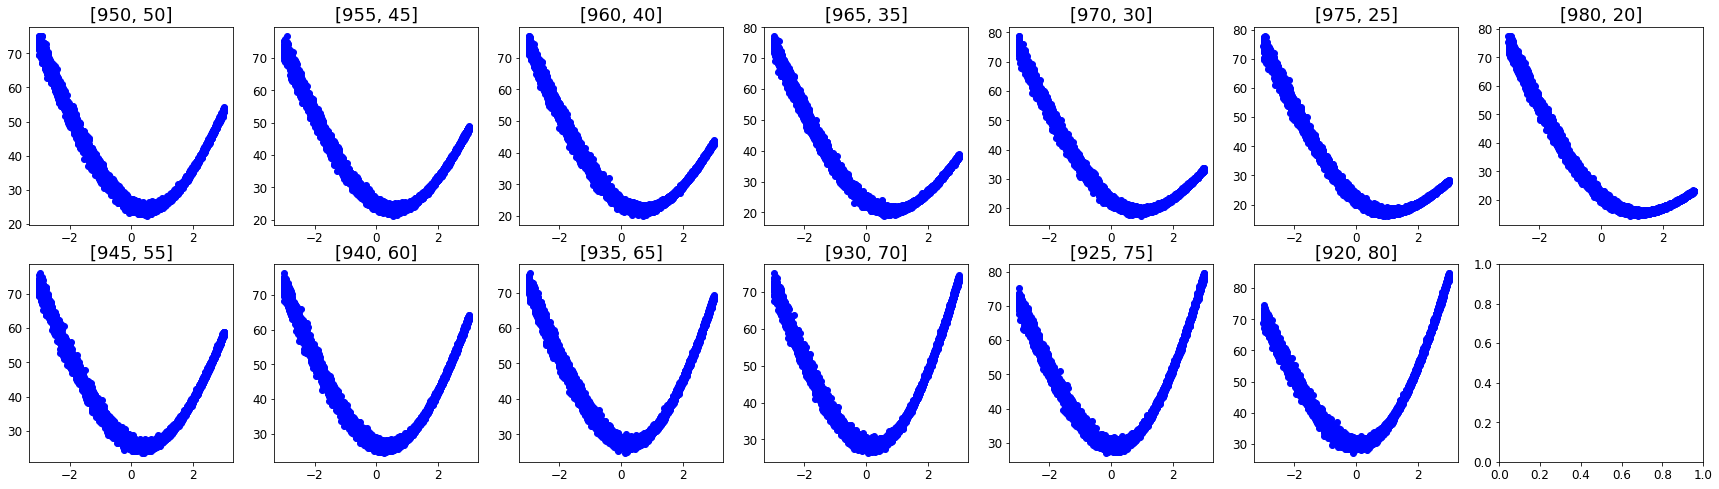

In [30]:
p_array = [[p_zeri, p_uni],[955, 45], [960, 40],[965, 35],[970, 30],[975, 25],[980, 20],[945, 55],[940, 60],[935, 65],[930, 70],[925, 75],[920, 80]]
losses = plot_losses_w_mu_weight(get_losses_bi, p_array)

## Pesi dopo none reduction

In [60]:
p_zeri/tot, p_uni/tot

(0.95, 0.05)

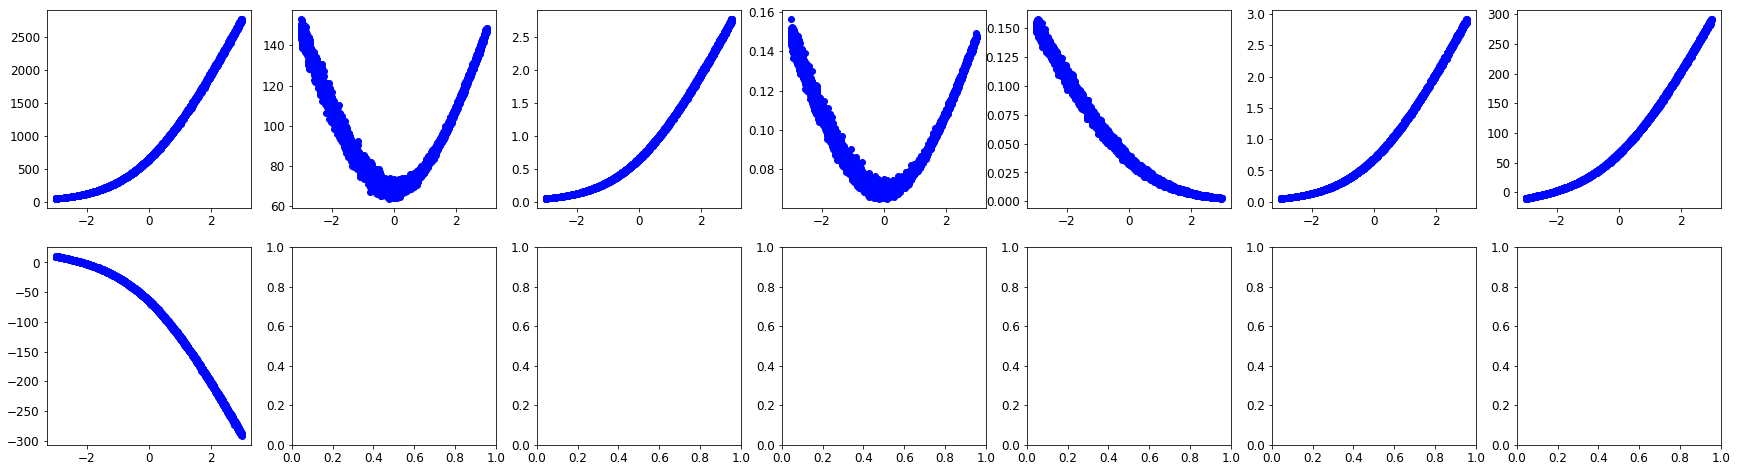

In [8]:
def all_weights2(custom_w):
    diz = {c:w for c, w in enumerate(custom_w)}
    return torch.tensor([diz[y] for y in y_true_shuf])
p_array = list(map(all_weights2,[[p_zeri, p_uni],[p_uni, p_zeri], [p_zeri/tot, p_uni/tot],[p_uni/tot, p_zeri/tot],[0.0, 1.0],[1.0, 0.0],[100, -100.0],[-100, 100]]))

plot_losses_w_mu_weight(get_losses_red, p_array, notitle=True)

In [ ]:
FACCIO LA VERIFICA CON DUE DISTRIBUZIONI COSTANTI, NON GAUSSIANE:  TUTTI VALORI -100 E + 100, IN MODO CHE SOTTO SIGMOIDE VENGONO TUTTI 0 E TUTTI 1,
QUINDI CALCOLO LA LOSS NEL CASO BILANCIATO, SBILANCIATO E SBILANCIATO PESATO

# Ripeto con la BCELoss

In [13]:
criterion = torch.nn.BCELoss()
criterion_wo_sigmoid_red = torch.nn.BCELoss(reduction='none')
custom_w = [19,1]
print(custom_w)  ## = [p_zeri,p_uni]
diz = {c:w for c, w in enumerate(custom_w[::-1])}
all_weights = lambda y_true: torch.tensor([diz[y] for y in y_true])

[19, 1]


In [14]:
print(f"pesi: {diz}")
print_f(calc_loss(criterion_wo_sigmoid_red, complementare=False, reduction=True, all_weights=all_weights))
print_f(calc_loss(criterion, complementare=False, reduction=False))

pesi: {0: 1, 1: 19}
Zeri: 0.56138               Centro: 1.32596               Uni: 2.9959               Ottimale: 0.42781
Zeri: 0.29547               Centro: 0.69787               Uni: 1.57679               Ottimale: 0.22516


pesi: {0: 50, 1: 950}
Zeri: 28.26708               Centro: 66.41901               Uni: 151.60992               Ottimale: 21.69512
Zeri: 0.29755               Centro: 0.69915               Uni: 1.59589               Ottimale: 0.22837


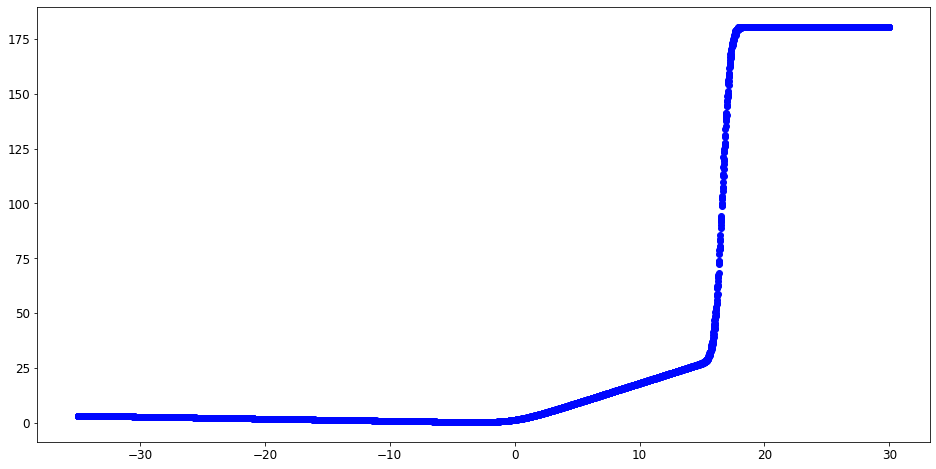

In [39]:
xs = np.arange(-35, 30, 0.01)
losses_mu = [get_losses_red(mu, all_weights) for mu in xs]
plt.scatter(xs, losses_mu)

plt.show()

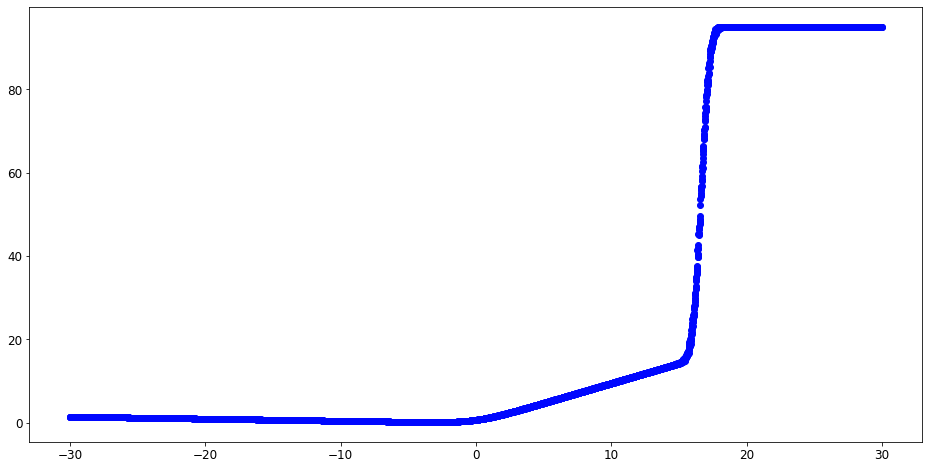

In [38]:
xs = np.arange(-30, 30, 0.01)
losses_mu = [get_losses_bceloss(mu) for mu in xs]
plt.scatter(xs, losses_mu)

plt.show()